In [1]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack

In [2]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
from pre_processamento import pre_processamento

In [6]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

In [7]:
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/MyDrive/Datasets/train.tsv', sep = '\t')
test = pd.read_csv('/content/drive/MyDrive/Datasets/test.tsv', sep = '\t')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train,test = pre_processamento(train,test)

In [9]:
X = train.drop("price", axis = 1)
y = train["price"]

In [10]:
X['name'].apply(lambda x: True if 'bundle' in x else False)

0          False
1          False
2          False
3          False
4          False
           ...  
1482530    False
1482531    False
1482532    False
1482533    False
1482534    False
Name: name, Length: 1481661, dtype: bool

In [11]:
y = y.drop(X[X['name'].apply(lambda x: 'bundle' in x)].index)
X = X.drop(X[X['name'].apply(lambda x: 'bundle' in x)].index)

#   Split

In [12]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.2, random_state=10) #Divisão em 80/20

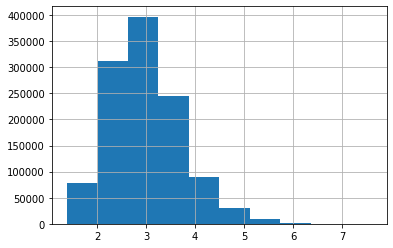

In [13]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

ytrain =  np.log1p(ytrain)
yval =  np.log1p(yval)
ytrain.hist()

In [14]:
Xtrain.head()

,name,item_condition_id,brand_name,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
1308880,"2 tops, Small and Mimi Chica dress, Med",3,FOREVER 21,0,"Forever 21 shark top, lightweight Gildan Unico...",2,Women,Tops & Blouses,"Tank, Cami",9.0,2018.0
870024,Paris a bra 36g brand new,1,NaN,0,Brand new. Never worn.,7,Women,Underwear,Bras,10.0,2018.0
327127,Victoria's secret Bikni top 32c,3,Victoria's Secret,0,Nice Victoria's secret 32c biknintop,15,Women,Swimwear,Two-Piece,6.0,2018.0
129984,Galaxy s7 Lifeproof Fre Case,1,NaN,1,Brand New Without Box Fits Galaxy S7,1,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",12.0,2018.0
1377836,VS Pink BackPack,1,PINK,1,Brand new with tags in online VS Bag VS Pink P...,2,Women,Women's Handbags,Backpack Style,10.0,2018.0


In [15]:
Xval.head()

,name,item_condition_id,brand_name,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
814448,Lularoe TC Leggings,2,LuLaRoe,0,TC Never Worn,13,Women,Athletic Apparel,"Pants, Tights, Leggings",10.0,2018.0
1249293,Merrell leather sandals size 8,3,Merrell,0,No description yet,1,Women,Shoes,Sandals,9.0,2018.0
943379,Victoria Secret the Nakeds,4,Victoria's Secret,0,2 Lined Demi,6,Women,Underwear,Bras,6.0,2018.0
510092,Stussy RUGBY HOODIE,1,NaN,0,Brand new with tags retails at [rm] asking 75$...,47,Men,Sweats & Hoodies,Hoodie,6.0,2018.0
841889,38DDD VS lined Body bra,3,Victoria's Secret,1,Lined Underwire Adjustable Straps Pilling on F...,26,Women,Underwear,Bras,10.0,2018.0


#   Pré-processamento

In [16]:
#Função para "separação" de palavras, ex: Can't -> can not, objetivo de facilitar a limpeza, aonde não serão criadas duas palavras para cant/can not.
# Será feito para diversas palavras com a mesma condição.

def text_preprocess(phrase):
    
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase  = re.sub('^no description yet$', '', phrase)
    
    phrase = re.sub('https?://\S+| www.\S+', '', phrase) #Remoção de qualquer site que possa ter no nosso dataset
    phrase  = re.sub('[rm]', '', phrase)
    phrase = re.sub("[^a-zA-Z0-9' \n\.]", '', phrase)  #excluindo tudo o que não for letra e numero.
    
    phrase = re.sub(' +', ' ', phrase) #exclusão de espaços extras, ex: "eu    vou" -> "eu vou"

    phrase = phrase.lower() #passando para letra minúscula.
   
    return phrase

In [17]:
Xtrain["name"] = Xtrain["name"].apply(lambda x: text_preprocess(x))

In [18]:
Xtrain["item_description"] = Xtrain["item_description"].astype(str)

In [19]:
Xtrain["item_description"] = Xtrain["item_description"].apply(lambda x: text_preprocess(x))

In [20]:
Xtrain

,name,item_condition_id,brand_name,shipping,item_description,stock,gen_cat,sub1_cat,sub2_cat,datetime_month,datetime_year
1308880,2 tops sall and mii chica dess med,3,FOREVER 21,0,foeve 21 shak top lightweight gildan unicon to...,2,Women,Tops & Blouses,"Tank, Cami",9.0,2018.0
870024,pais a ba 36g band new,1,NaN,0,band new. neve won.,7,Women,Underwear,Bras,10.0,2018.0
327127,victoia is secet bikni top 32c,3,Victoria's Secret,0,nice victoia is secet 32c biknintop,15,Women,Swimwear,Two-Piece,6.0,2018.0
129984,galaxy s7 lifepoof fe case,1,NaN,1,band new without box fits galaxy s7,1,Electronics,Cell Phones & Accessories,"Cases, Covers & Skins",12.0,2018.0
1377836,vs pink backpack,1,PINK,1,band new with tags in online vs bag vs pink pi...,2,Women,Women's Handbags,Backpack Style,10.0,2018.0
...,...,...,...,...,...,...,...,...,...,...,...
1374262,pink,3,PINK,1,t shit bling,18,Women,Tops & Blouses,T-Shirts,6.0,2018.0
1176292,tie dye tunicdess,2,NaN,1,geat condition shows no sign of wea quate sleeve,13,Women,Tops & Blouses,T-Shirts,2.0,2018.0
629826,lululeon high ties pants sz 6,1,Lululemon,1,nwt size 6 heatheed slate gey cottony soft luo...,9,Women,Athletic Apparel,"Pants, Tights, Leggings",8.0,2018.0
1068678,cantu,1,NaN,1,band new neve used cantu shea butte leave in c...,11,Beauty,Hair Care,Conditioners,8.0,2018.0


In [21]:
vec_name = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df = 50, max_df = 0.5) #vetorização, com stop word. 
vec_desc = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df = 50, max_df = 0.5) #vetorização, com stop word. 

vce_xtrain_name = vec_name.fit_transform(Xtrain["name"])
vce_xtrain_descrip = vec_desc.fit_transform(Xtrain["item_description"])

In [22]:
vce_xtrain_descrip

<1163609x55267 sparse matrix of type '<class 'numpy.float64'>'
	with 25600718 stored elements in Compressed Sparse Row format>

In [23]:
vce_xtrain_name

<1163609x13612 sparse matrix of type '<class 'numpy.float64'>'
	with 5461329 stored elements in Compressed Sparse Row format>

In [24]:
ohe = OneHotEncoder(handle_unknown="ignore")

#aplicação dummy nas colunas categóricas.

ohe_condition = ohe.fit_transform(Xtrain[["item_condition_id",   
                                         "shipping",
                                         #"brand_name",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat"]])
                                         #"datetime_month"]])

In [25]:
ohe_condition

<1163609x996 sparse matrix of type '<class 'numpy.float64'>'
	with 5818045 stored elements in Compressed Sparse Row format>

In [26]:
x_train = hstack([(vce_xtrain_name), (vce_xtrain_descrip), (ohe_condition)], format='csr')

In [27]:
x_train.shape[-1]

69875

In [28]:
from tensorflow.keras.backend import clear_session

clear_session()

In [29]:
from keras.layers import Input, Dense
from keras.models import Model

input = Input(shape=(x_train.shape[-1]), sparse=True, name='sparse')
dense3 = Dense(1024, activation="relu") (input)
dense4 = Dense(512, activation="relu") (dense3)
dense5 = Dense(256, activation="relu") (dense4)
dense6 = Dense(1) (dense5)

model = Model(inputs = input, outputs = dense6)

model.summary()

#Tentar dropar os bundles

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sparse (InputLayer)         [(None, 69875)]           0         
                                                                 
 dense (Dense)               (None, 1024)              71553024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 72,209,409
Trainable params: 72,209,409
Non-trainable params: 0
_________________________________________________________________


In [30]:
ytrain.values.shape

(1163609,)

In [31]:
from tensorflow.keras.metrics import RootMeanSquaredError

model.compile(loss="mean_absolute_error", metrics=['mean_squared_error', 'mean_squared_logarithmic_error', RootMeanSquaredError()], optimizer = 'adam')
history1 = model.fit(x_train, ytrain.values, batch_size=2048, epochs=10, verbose=True)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 1024), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


569/569 [==============================] - 40s 64ms/step - loss: 0.3990 - mean_squared_error: 0.3180 - mean_squared_logarithmic_error: 0.0254 - root_mean_squared_error: 0.5639
Epoch 2/10
569/569 [==============================] - 39s 64ms/step - loss: 0.3184 - mean_squared_error: 0.1877 - mean_squared_logarithmic_error: 0.0116 - root_mean_squared_error: 0.4333
Epoch 3/10
569/569 [==============================] - 39s 65ms/step - loss: 0.2767 - mean_squared_error: 0.1486 - mean_squared_logarithmic_error: 0.0092 - root_mean_squared_error: 0.3856
Epoch 4/10
569/569 [==============================] - 39s 64ms/step - loss: 0.2388 - mean_squared_error: 0.1159 - mean_squared_logarithmic_error: 0.0072 - root_mean_squared_error: 0.3404
Epoch 5/10
569/569 [==============================] - 39s 64ms/step - loss: 0.2073 - mean_squared_error: 0.0909 - mean_squared_logarithmic_error: 0.0056 - root_mean_squared_error: 0.3016
Epoch 6/10
569/569 [==============================] - 39s 64ms/step - loss: 

In [32]:
Xval["name"] = Xval["name"].apply(lambda x: text_preprocess(x))
Xval["item_description"] = Xval["item_description"].astype(str)
Xval["item_description"] = Xval["item_description"].apply(lambda x: text_preprocess(x))

vce_xval_name = vec_name.transform(Xval["name"])
vce_xval_descrip = vec_desc.transform(Xval["item_description"])

ohe_val_condition = ohe.transform(Xval[["item_condition_id",   
                                          "shipping",
                                          #"brand_name"
                                          "gen_cat",
                                          "sub1_cat",
                                          "sub2_cat"]])
                                          #"datetime_month"



x_val = hstack([ (vce_xval_name), (vce_xval_descrip), (ohe_val_condition)], format='csr')

In [33]:
print("\n")
scoreMLP = model.evaluate(x_val, yval.values)
print(model.metrics_names)
print("mse: ", scoreMLP[1])
print("msle: ", scoreMLP[2])
print("rmse: ", scoreMLP[3])



9091/9091 [==============================] - 33s 4ms/step - loss: 0.3363 - mean_squared_error: 0.2055 - mean_squared_logarithmic_error: 0.0128 - root_mean_squared_error: 0.4534
['loss', 'mean_squared_error', 'mean_squared_logarithmic_error', 'root_mean_squared_error']
mse:  0.20553001761436462
msle:  0.01281614787876606
rmse:  0.4533541798591614


In [34]:
import math
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

yval = [math.exp(i)-1 for i in yval.values]

In [35]:
y_pred = [math.exp(i)-1 for i in model.predict(x_val)]

print(mean_absolute_error(yval,y_pred))
print(mean_squared_error(yval,y_pred))
print(mean_squared_log_error(yval,y_pred))

10.267726677120333
913.7634213007858
0.2055301448541738


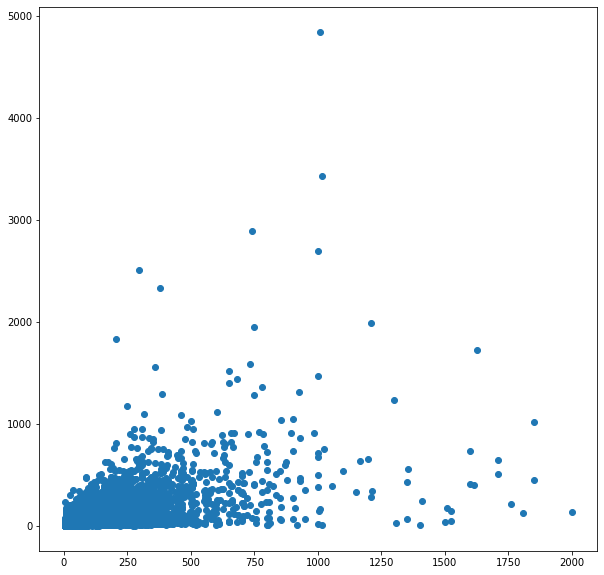

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(x=yval, y=y_pred)